<a href="https://colab.research.google.com/github/AdamCorbinFAUPhD/CIRCLe-experiments/blob/main/CIRCLe_with_isic2018_with_skin_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This notebook is used to modify the implementation of CIRCLe from this paper : [CIRCLe: Color Invariant Representation
Learning for Unbiased Classification of Skin
Lesions](https://arxiv.org/pdf/2208.13528.pdf)

Their github repo is : https://github.com/arezou-pakzad/CIRCLe

This paper uses the Fitzpatrick17k dataset which can be obtained here: https://github.com/mattgroh/fitzpatrick17k

For these set of experiments we will use the ISIC 2017 dataset from: https://github.com/manideep2510/melanoma_segmentation.git 

#TODO list

1. [X] Download 2018 dataset
1. [X] Analize dataset to get Fitzpatrick info. 
1. [X] Save off Fitzpatrick info data so we dont have to do it every time
1. [X] load cached fitzpatrick data
1. [X] Create masks uing https://github.com/DebeshJha/2020-CBMS-DoubleU-Net Because Task 3 for 2018 doesnt havent masks. Trick was to get the higher end GPU and ram (12/29/2022)
1. [X] Create pytorch dataloader for ISIC 2018 dataset including loading masks, images, diagnossis, fitzpatrick type for training (12/30/2022) needed to create custom split function
1. [X] Create dataloaders for test and validation  (12/30/2022)
1. [X] Added jupiter notebook download code into the github repo (1/1/2023)
1. [X] plug in dataloader into CIRCLe main file (1/1/2023)
1. [X] Figure out how to transform image and mask the same from the dataloader (1/2/2023)
1. [X] Use the new dataloader to train the model (1/2/2023)
1. [ ] Use new transformer for CIRCLe model
1. [ ] Go back and download and use larger datasets
1. [ ] Run Fitzpatrick on larger datasets(currently using the test set from isic 2018 task 3)
1. [ ] The dataloaders need to be split stratified different than the current "training, validation, and test" as given from https://challenge.isic-archive.com/data/#2018 based on skin types. 12/30/2022 - I think this is done BUT we might consider doing k-fold approach which adds another layer of complexity to the dataloaders

# Set up the environment

In [ ]:
!python --version
DATASET_USED = "ISIC_2018"  # ISIC_2017_ORIG, ISIC_2018

Python 3.8.16


## Installs & imports

In [ ]:
import zipfile
import torch

from enum import Enum
import io
import math
from pathlib import Path
import random

import numpy as np
import seaborn as sns, matplotlib.pyplot as plt


import skimage
from skimage import color, util

import PIL
from PIL import ImageStat
from PIL import Image
from PIL import ImageOps

import cv2

import pandas as pd

import glob
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import *

from sklearn.model_selection import train_test_split

from torchvision import transforms

## Download latest code

In [ ]:
!git clone https://github.com/acorbin3/CIRCLe.git

fatal: destination path 'CIRCLe' already exists and is not an empty directory.


In [ ]:
%cd ./CIRCLe

/content/CIRCLe


In [55]:
!git checkout -- models/circle.py

In [60]:
!git pull

Updating e3f8683..3825a7f
Fast-forward
 models/circle.py                   | 32 ++++++++++++++++----------------
 organize_data/isic_2018/dataset.py |  2 +-
 2 files changed, 17 insertions(+), 17 deletions(-)


In [ ]:
!pip3 install -r ./requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download ISIC dataset

## ISIC 2017

In [ ]:
%%time
if DATASET_USED == "ISIC_2017_ORIG":    
    !wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Validation_Data.zip
    !wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Validation_Part1_GroundTruth.zip
    !wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Validation_Part3_GroundTruth.csv

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [ ]:
%%time
if DATASET_USED == "ISIC_2017_ORIG":
    !unzip ISIC-2017_Validation_Data.zip -d ISIC_2017/validation > /dev/null.
    !unzip ISIC-2017_Validation_Part1_GroundTruth.zip -d ISIC_2017/validation_GT > /dev/null.

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


## ISIC 2018

In [ ]:
%%time
if DATASET_USED == "ISIC_2018":
    # Task 1 (this has masks but doesnt have classification ground truth)
    #!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip
    #!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip
    # Task 3 (This has classification ground truth but doesnt have masks)
    !wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip
    !wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip

--2023-01-02 08:02:26--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.228.169, 52.217.79.156, 52.216.95.187, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|54.231.228.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2771732744 (2.6G) [application/zip]
Saving to: ‘ISIC2018_Task3_Training_Input.zip’

SIC2018_Task3_Train   0%[                    ]  11.55M  4.69MB/s               ^C
--2023-01-02 08:02:30--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.235.9, 52.216.239.59, 54.231.227.73, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.235.9|:443... connected.
HTTP request sent, awaiting respo

In [ ]:
%%time
if DATASET_USED == "ISIC_2018":
    !unzip ISIC2018_Task3_Training_Input.zip -d ISIC_2018 > /dev/null.
    !unzip ISIC2018_Task3_Training_GroundTruth.zip -d ISIC_2018_GT > /dev/null.
     

CPU times: user 117 ms, sys: 56.1 ms, total: 173 ms
Wall time: 18.2 s


## Organize the images into arrays

In [ ]:
%%time
"""
This section we read all the images including their masks. 
"""

orig_images = []
masks_images = []


if DATASET_USED == "ISIC_2017_ORIG":
    for file in Path(f"ISIC_2017/validation").glob("**/*.jp*"):
        if not("super" in str(file)):
            orig_images.append(file)        
    for file in Path(f"ISIC_2017/validation").glob("**/*.jpg"):
        masks_images.append(file)
elif DATASET_USED == "ISIC_2018":
    for file in Path("ISIC_2018").glob("**/*.jpg"):        
        orig_images.append(file)

    #TODO - no masks for Task 3, will need to use some ML to generate some masks
    # for now use empty strings
    masks_images = [""] * len(orig_images)    

print(len(orig_images))
print(len(masks_images))

10015
10015
CPU times: user 82.3 ms, sys: 17.9 ms, total: 100 ms
Wall time: 123 ms


## Create main dataframe

## Check to see if we can used cached data

In [ ]:
%%time
isic_df = None
data_cached = False
if DATASET_USED == "ISIC_2018":
    for file in Path("/content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/").glob("**/*.csv"):
        print(file)
        if "isic_2018" in file.name:            
            isic_df = pd.read_csv(file)
            isic_df = isic_df.fillna("")
            print(isic_df.head())
            data_cached = True
            
#saved_data_2022_12_27_isic_2018

/content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/isic_saved_data/saved_data_2022_12_27_isic_2018.csv
   Unnamed: 0                                         image_path mask_path  \
0           0  ISIC_2018/ISIC2018_Task3_Training_Input/ISIC_0...             
1           1  ISIC_2018/ISIC2018_Task3_Training_Input/ISIC_0...             
2           2  ISIC_2018/ISIC2018_Task3_Training_Input/ISIC_0...             
3           3  ISIC_2018/ISIC2018_Task3_Training_Input/ISIC_0...             
4           4  ISIC_2018/ISIC2018_Task3_Training_Input/ISIC_0...             

   fizpatrick_skin_type      image_id MEL  NV BCC AKIEC  BKL DF VASC label  \
0                     1  ISIC_0033511      NV                           NV   
1                     1  ISIC_0027866      NV                           NV   
2                     1  ISIC_0025232      NV                           NV   
3                     1  ISIC_0027435                    BKL           BKL   
4   

### Ground Truth data parsing

In [ ]:
if DATASET_USED == "ISIC_2017_ORIG":
    csv_files = glob.glob("**/ISIC-2017_Validation_Part3_GroundTruth.csv", recursive=True)
elif DATASET_USED == "ISIC_2018":
    csv_files = Path("ISIC_2018_GT").glob("**/*.csv")

dfs = []
for f in csv_files:    
    if "ISIC" in str(f):
        print(f)
        dfs.append(pd.read_csv(f))

ISIC_2018_GT/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


In [ ]:
dfs[0].head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Create main dataframe
if isic_df is None:
    isic_df = pd.DataFrame()

    isic_df["image_path"] = orig_images
    isic_df["mask_path"] = masks_images
    isic_df["fizpatrick_skin_type"] = ""
    isic_df["image_id"] = isic_df["image_path"].apply(lambda x: x.name.split('.')[0])
    if DATASET_USED == "ISIC_2017_ORIG":
        isic_df = pd.merge(isic_df, dfs[0], on="image_id")
    elif DATASET_USED == "ISIC_2018":
        dfs[0].rename(columns={"image":"image_id"}, inplace=True)    
        isic_df = pd.merge(isic_df, dfs[0], on="image_id")

        # Clean up columns for further process
        # replaces 1's with column name
        isic_df.loc[isic_df["MEL"] == 1.0, ["MEL"]] = "MEL"
        isic_df.loc[isic_df["NV"] == 1.0, ["NV"]] = "NV"
        isic_df.loc[isic_df["AKIEC"] == 1.0, ["AKIEC"]] = "AKIEC"
        isic_df.loc[isic_df["BKL"] == 1.0, ["BKL"]] = "BKL"
        isic_df.loc[isic_df["BCC"] == 1.0, ["BCC"]] = "BCC"
        isic_df.loc[isic_df["DF"] == 1.0, ["DF"]] = "DF"
        isic_df.loc[isic_df["VASC"] == 1.0, ["VASC"]] = "VASC"

        # Clear out the 0's
        isic_df.loc[isic_df["MEL"] == 0, ["MEL"]] = ""
        isic_df.loc[isic_df["NV"] == 0, ["NV"]] = ""
        isic_df.loc[isic_df["AKIEC"] == 0, ["AKIEC"]] = ""
        isic_df.loc[isic_df["BKL"] == 0, ["BKL"]] = ""
        isic_df.loc[isic_df["BCC"] == 0, ["BCC"]] = ""
        isic_df.loc[isic_df["DF"] == 0, ["DF"]] = ""
        isic_df.loc[isic_df["VASC"] == 0, ["VASC"]] = ""

        

In [ ]:
isic_df.head()

,Unnamed: 0,image_path,mask_path,fizpatrick_skin_type,image_id,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label,label_encoded,ita
0,0,ISIC_2018/ISIC2018_Task3_Training_Input/ISIC_0...,,1,ISIC_0033511,,NV,,,,,,NV,5,113.738539
1,1,ISIC_2018/ISIC2018_Task3_Training_Input/ISIC_0...,,1,ISIC_0027866,,NV,,,,,,NV,5,65.330533
2,2,ISIC_2018/ISIC2018_Task3_Training_Input/ISIC_0...,,1,ISIC_0025232,,NV,,,,,,NV,5,72.239115
3,3,ISIC_2018/ISIC2018_Task3_Training_Input/ISIC_0...,,1,ISIC_0027435,,,,,BKL,,,BKL,2,100.821082
4,4,ISIC_2018/ISIC2018_Task3_Training_Input/ISIC_0...,,2,ISIC_0032377,,NV,,,,,,NV,5,51.662545


In [ ]:
if DATASET_USED == "ISIC_2018":
    encoder = LabelEncoder()
    isic_df["label"] = isic_df[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]].apply(lambda x: "".join(x), axis=1)
    isic_df["label_encoded"] = encoder.fit_transform(isic_df["label"])

In [ ]:
isic_df.head()

,Unnamed: 0,image_path,mask_path,fizpatrick_skin_type,image_id,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label,label_encoded,ita
0,0,ISIC_2018/ISIC2018_Task3_Training_Input/ISIC_0...,,1,ISIC_0033511,,NV,,,,,,NV,5,113.738539
1,1,ISIC_2018/ISIC2018_Task3_Training_Input/ISIC_0...,,1,ISIC_0027866,,NV,,,,,,NV,5,65.330533
2,2,ISIC_2018/ISIC2018_Task3_Training_Input/ISIC_0...,,1,ISIC_0025232,,NV,,,,,,NV,5,72.239115
3,3,ISIC_2018/ISIC2018_Task3_Training_Input/ISIC_0...,,1,ISIC_0027435,,,,,BKL,,,BKL,2,100.821082
4,4,ISIC_2018/ISIC2018_Task3_Training_Input/ISIC_0...,,2,ISIC_0032377,,NV,,,,,,NV,5,51.662545


In [ ]:
# Just making sure we didnt have any items with multiple classes
isic_df["label"].unique()

array(['NV', 'BKL', 'MEL', 'AKIEC', 'BCC', 'VASC', 'DF'], dtype=object)

## Compute Fitzpatrick data
This section will go over each file and compute the Fitzpatrick data

In [ ]:
if not data_cached:
    get_cropped_center_ita(image=Image.open(orig_images[0]))

In [ ]:
if not data_cached:
    isic_df["ita"] = isic_df["image_path"].apply(lambda x: get_cropped_center_ita(image=Image.open(x)))

In [ ]:
if not data_cached:
    isic_df["fizpatrick_skin_type"] = isic_df["ita"].apply(lambda ita: get_kinyanjui_groh_type(ita))

In [ ]:
if not data_cached:
    isic_df.to_csv("saved_data_2022_12_27_isic_2018.csv")

In [ ]:
if not data_cached:
    isic_df.head()



In [ ]:
isic_df.iloc[0]

Unnamed: 0                                                              0
image_path              ISIC_2018/ISIC2018_Task3_Training_Input/ISIC_0...
mask_path                                                                
fizpatrick_skin_type                                                    1
image_id                                                     ISIC_0033511
MEL                                                                      
NV                                                                     NV
BCC                                                                      
AKIEC                                                                    
BKL                                                                      
DF                                                                       
VASC                                                                     
label                                                                  NV
label_encoded                         

## Get ISIC 2018 Cached masks

In [ ]:
%cp /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/isic_2018_mask_results2_2022_12_29.zip /content/CIRCLe/

In [ ]:
!unzip isic_2018_mask_results2_2022_12_29.zip -d ISIC_2018 > /dev/null.

In [ ]:
isic_df["mask_path"] = isic_df["image_id"].apply(lambda x: f"ISIC_2018/results2/{x}.png")

In [ ]:
import os
# resize all images to match the dimentions of the ISIC 2018 images
# Set the target size
target_size = (600, 450)
mask_directory = "ISIC_2018/results2"
# Iterate over all the files in the directory
for file in os.listdir(mask_directory):
    # Skip files that are not images
    if not file.endswith(".jpg") and not file.endswith(".png"):
        continue
        
    # Open the image
    im = Image.open(os.path.join(mask_directory, file))
    
    # Resize the image
    im_resized = im.resize(target_size)
    
    # Save the resized image
    im_resized.save(os.path.join(mask_directory, file))

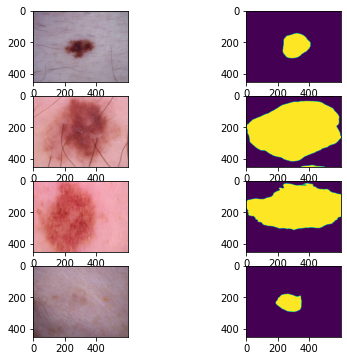

In [ ]:
count = 3
plt.figure(figsize=(7,count * 2))


# Loop over the DataFrame
for i, row in isic_df.iterrows():
    if i > count:
        break
    # Get the image data
    img_data = Image.open(row["image_path"])
    #print(img_data.size)
    mask_data = Image.open(row["mask_path"])
    #mask_data = mask_data.rotate(90)

    # Add the image to the plot
    plt.subplot(count+1, 2, i*2+1)
    plt.imshow(img_data)
    
    # Add the mask to the plot
    plt.subplot(count+1, 2, i*2+2)
    plt.imshow(mask_data)



# Show the plot
plt.show()

## Create masks when not avaliable
For the ISIC 2018 Task 3 challenge for the classification challenge it doesnt provide skin lesion masks. Due to this we will need to generate masks. The fastest way is to find an open source skin lesion mask model to generate the masks. We will be using this model since its open souced, performed well on the 2018 Task 1(skin lesion segmentation) and the weights have been provided: https://github.com/DebeshJha/2020-CBMS-DoubleU-Net

Weights file: https://drive.google.com/file/d/1jjMYoMkbb866-1qh3bD546TVp-ZjKs9w/view?usp=sharing

### Set up DoubleU-Net

In [ ]:
%cp /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/DoubleUNet.zip /content/CIRCLe/

In [ ]:
file_name_with_path = "/content/CIRCLe/DoubleUNet.zip"
with zipfile.ZipFile(file_name_with_path, 'r') as zip_ref:
    zip_ref.extractall("/content/CIRCLe")

In [ ]:
path_to_model_h5 = '/content/CIRCLe/DoubleUNet/files/model.h5'

#### Main model

In [ ]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

# def encoder2(inputs):
#     skip_connections = []
#
#     output = DenseNet121(include_top=False, weights='imagenet')(inputs)
#     model = tf.keras.models.Model(inputs, output)
#
#     names = ["input_2", "conv1/relu", "pool2_conv", "pool3_conv"]
#     for name in names:
#         skip_connections.append(model.get_layer(name).output)
#     output = model.get_layer("pool4_conv").output
#
#     return output, skip_connections

def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    outputs = Concatenate()([outputs1, outputs2])

    model = Model(inputs, outputs)
    return model

#### utils


In [ ]:

smooth = 1e-15

def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
    alpha=0.25
    gamma=2
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

In [ ]:
def load_model_weight(path):
    with CustomObjectScope({
        'dice_loss': dice_loss,
        'dice_coef': dice_coef,
        'bce_dice_loss': bce_dice_loss,
        'focal_loss': focal_loss,
        'iou': iou
        }):
        model = load_model(path)
    return model

In [ ]:
def read_image(x):
    if isinstance(x, Image.Image):
        # Convert the PIL image to a NumPy array
        np_image = np.array(x)

        # Convert the NumPy array to a cv2 image
        image = cv2.imdecode(np_image, cv2.IMREAD_COLOR)
    else: # case when x is a path to a file
        image = cv2.imread(x, cv2.IMREAD_COLOR)

    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    image = np.expand_dims(image, axis=0)
    return image

def mask_to_3d(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

def parse(y_pred):
    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = y_pred[..., -1]
    y_pred = y_pred.astype(np.float32)
    y_pred = np.expand_dims(y_pred, axis=-1)
    return y_pred

In [ ]:
!mkdir results
!mkdir results1
!mkdir results2

mkdir: cannot create directory ‘results’: File exists


In [ ]:
def generate_mask(model, image_path):
    image = Image.open(image_path).resize((512,384))
    image.save(resize_folder/image_path.name)
    print(f"saved to: {resize_folder/image_path.name}")
    x = read_image(str(resize_folder/image_path.name))
    _, h, w, _ = x.shape

    line = np.ones((h, 10, 3)) * 255.0

    y_pred1 = parse(model.predict(x)[0][..., -2])
    y_pred2 = parse(model.predict(x)[0][..., -1])

    all_images = [            
            mask_to_3d(y_pred1) * 255.0, line,
            mask_to_3d(y_pred2) * 255.0
        ]

    mask1 = np.concatenate(mask_to_3d(y_pred1) * 255.0, axis=1)
    mask2 = np.concatenate(mask_to_3d(y_pred2) * 255.0, axis=1)

    cv2.imwrite(f"results1/{image_path.name.split('.')[0]}.png", mask1)
    cv2.imwrite(f"results2/{image_path.name.split('.')[0]}.png", mask2)


In [ ]:
model = load_model_weight(path_to_model_h5)

ISIC_2018/ISIC2018_Task3_Training_Input/ISIC_0027866.jpg


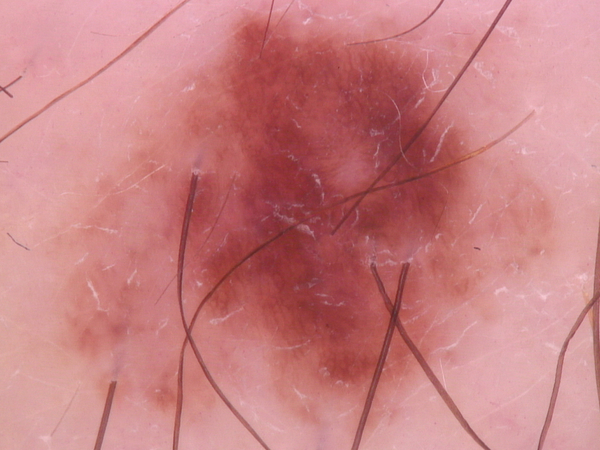

In [ ]:
image_path = isic_df.iloc[1]["image_path"]
print(image_path)
Image.open(image_path)

In [ ]:
resize_folder = Path("/content/CIRCLe/ISIC_2018/ISIC2018_Task3_Training_Input_resize")
resize_folder.mkdir()

In [ ]:
Path(isic_df.iloc[0]["image_path"]).name

'ISIC_0033511.jpg'

### Generate all masks

In [ ]:
count = 0
size = len(isic_df)
break_point = size
for index, row in isic_df.iterrows():
    if count == break_point:
        break
    print(index, count,f"percent done: {100 * (index + 1)/size} (count/size)({index+1}/{size})" )
    generate_mask(model, Path(isic_df.iloc[index]["image_path"]))
    count += 1

Streaming output truncated to the last 5000 lines.
saved to: /content/CIRCLe/ISIC_2018/ISIC2018_Task3_Training_Input_resize/ISIC_0029243.jpg
1/1 [==============================] - 0s 41ms/step
8766 8766 percent done: 87.53869196205692 (count/size)(8767/10015)
saved to: /content/CIRCLe/ISIC_2018/ISIC2018_Task3_Training_Input_resize/ISIC_0034278.jpg
1/1 [==============================] - 0s 41ms/step
8767 8767 percent done: 87.54867698452321 (count/size)(8768/10015)
saved to: /content/CIRCLe/ISIC_2018/ISIC2018_Task3_Training_Input_resize/ISIC_0028482.jpg
1/1 [==============================] - 0s 42ms/step
8768 8768 percent done: 87.55866200698952 (count/size)(8769/10015)
saved to: /content/CIRCLe/ISIC_2018/ISIC2018_Task3_Training_Input_resize/ISIC_0031452.jpg
1/1 [==============================] - 0s 42ms/step
8769 8769 percent done: 87.56864702945582 (count/size)(8770/10015)
saved to: /content/CIRCLe/ISIC_2018/ISIC2018_Task3_Training_Input_resize/ISIC_0031596.jpg
1/1 [==================

In [ ]:
# Zip up directory, copy it over to google drive
!zip -r isic_2018_mask_results1_2022_12_29.zip results1
%cp isic_2018_mask_results1_2022_12_29.zip /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/

!zip -r isic_2018_mask_results2_2022_12_29.zip results2
%cp isic_2018_mask_results2_2022_12_29.zip /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/

Streaming output truncated to the last 5000 lines.
  adding: results2/ISIC_0033481.png (deflated 25%)
  adding: results2/ISIC_0025089.png (deflated 20%)
  adding: results2/ISIC_0026283.png (deflated 22%)
  adding: results2/ISIC_0025691.png (deflated 46%)
  adding: results2/ISIC_0026992.png (deflated 13%)
  adding: results2/ISIC_0024413.png (deflated 20%)
  adding: results2/ISIC_0024813.png (deflated 36%)
  adding: results2/ISIC_0025391.png (deflated 18%)
  adding: results2/ISIC_0028775.png (deflated 10%)
  adding: results2/ISIC_0032860.png (deflated 17%)
  adding: results2/ISIC_0028433.png (deflated 27%)
  adding: results2/ISIC_0031405.png (deflated 7%)
  adding: results2/ISIC_0028783.png (deflated 18%)
  adding: results2/ISIC_0029102.png (deflated 27%)
  adding: results2/ISIC_0025438.png (deflated 14%)
  adding: results2/ISIC_0034210.png (deflated 24%)
  adding: results2/ISIC_0030338.png (deflated 33%)
  adding: results2/ISIC_0026104.png (deflated 28%)
  adding: results2/ISIC_0030157.

saved to: /content/CIRCLe/ISIC_2018/ISIC2018_Task3_Training_Input_resize/ISIC_0033511.jpg
1/1 [==============================] - 0s 41ms/step


### Set up BA-Transformer

In [ ]:
!git clone https://github.com/jcwang123/BA-Transformer.git

Cloning into 'BA-Transformer'...
remote: Enumerating objects: 350, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 350 (delta 27), reused 22 (delta 18), pack-reused 308
Receiving objects: 100% (350/350), 15.30 MiB | 22.54 MiB/s, done.
Resolving deltas: 100% (143/143), done.


In [ ]:
%cp /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/isic2016.zip /content/CIRCLe/

In [ ]:
file_name_with_path = "/content/CIRCLe/isic2016.zip"
with zipfile.ZipFile(file_name_with_path, 'r') as zip_ref:
    zip_ref.extractall("/content/CIRCLe")

In [ ]:
path_to_model_h5 = '/content/CIRCLe/DoubleUNet/files/model.h5'

In [ ]:
import torch
import torch.nn as nn
from collections import OrderedDict


def load_model(model, pretrain_dir, log=True):
    state_dict_ = torch.load(pretrain_dir, map_location='cuda:0')
    print('loaded pretrained weights form %s !' % pretrain_dir)
    state_dict = OrderedDict()

    # convert data_parallal to model
    for key in state_dict_:
        if key.startswith('module') and not key.startswith('module_list'):
            state_dict[key[7:]] = state_dict_[key]
        else:
            state_dict[key] = state_dict_[key]

# check loaded parameters and created model parameters
    model_state_dict = model.state_dict()
    for key in state_dict:
        if key in model_state_dict:
            #       print(key,state_dict[key].shape,model_state_dict[key].shape)
            if state_dict[key].shape != model_state_dict[key].shape:
                if log:
                    print(
                        'Skip loading parameter {}, required shape{}, loaded shape{}.'
                        .format(key, model_state_dict[key].shape,
                                state_dict[key].shape))
                state_dict[key] = model_state_dict[key]
        else:
            if log:
                print('Drop parameter {}.'.format(key))
    for key in model_state_dict:
        if key not in state_dict:
            if log:
                print('No param {}.'.format(key))
            state_dict[key] = model_state_dict[key]
    model.load_state_dict(state_dict, strict=False)

    return model

### Set up BCDU-Net

In [ ]:
!git clone https://github.com/rezazad68/BCDU-Net.git

Cloning into 'BCDU-Net'...
remote: Enumerating objects: 577, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 577 (delta 21), reused 37 (delta 10), pack-reused 527
Receiving objects: 100% (577/577), 13.41 MiB | 15.17 MiB/s, done.
Resolving deltas: 100% (278/278), done.


In [ ]:
%cp /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/model_checkpoints/BCDU-Net/weight_isic18.hdf5 /content/CIRCLe/

In [ ]:
path_to_model_h5 = '/content/CIRCLe/weight_isic18.hdf5'

#### model

In [ ]:
from __future__ import division
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD
from keras.optimizers import *
from keras.layers import *        
from keras.applications.vgg16 import VGG16
import keras



def BCDU_net_D3(input_size = (256,256,1)):
    N = input_size[0]
    inputs = Input(input_size) 
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)     
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)     
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)

    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1) 
    merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)
            
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1) 
    merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)    

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1) 
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(inputs = inputs, outputs = conv9)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model
    
def BCDU_net_D1(input_size = (256,256,1)):
    N = input_size[0]
    inputs = Input(input_size) 
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)

    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_1)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1) 
    merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)
            
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1) 
    merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)    

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1) 
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(input = inputs, output = conv9)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

       
def unet(input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
    merge6 = concatenate([drop3,up6], axis = 3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv2,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv1,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(input = inputs, output = conv9)
    
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model
    
def SqueezeExcite(x, ratio=16):
    nb_chan = K.int_shape(x)[-1]

    y = GlobalAveragePooling2D()(x)
    y = Dense(nb_chan // ratio, activation='relu')(y)
    y = Dense(nb_chan, activation='sigmoid')(y)

    y = Multiply()([x, y])
    return y

WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.1/'
                       'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

def SEDU_Net_D3(input_size = (256,256,1), learning_rate = 1e-4):
    img_input = Input(input_size) 
    N = input_size[0]
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    conv1 = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(conv1)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(pool1)
    conv2 = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    pool2 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(conv2)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(pool2)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    conv3 = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    pool3 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(conv3)
    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(pool3)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    # D1
    drop4_1 = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    # D2
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)     
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)     
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)
    
    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = SqueezeExcite(up6, ratio=16) 
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(conv3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1) 
    merge6 = ConvLSTM2D(filters = 256, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)
            
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = SqueezeExcite(conv6, ratio=16) 
    
    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = SqueezeExcite(up7, ratio=16)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1) 
    merge7 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = SqueezeExcite(conv7, ratio=16)
    
    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = SqueezeExcite(up8, ratio=16)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)    

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1) 
    merge8 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = SqueezeExcite(conv8, ratio=16)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    # Load weights.
    weights_path = keras.utils.get_file(
                   'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                   WEIGHTS_PATH_NO_TOP,
                   cache_subdir='models',
                   file_hash='6d6bbae143d832006294945121d1f1fc')
    model = Model(input = img_input, output = conv9)
    model.load_weights(weights_path, by_name=True)

    model.compile(optimizer = Adam(lr = learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model


#### setup model

In [ ]:
model = BCDU_net_D3(input_size = (256,256,3))

In [ ]:
model.load_weights('weight_isic18.hdf5')

##### prepare data for the model to read

In [ ]:
import scipy.io as sio
import scipy.misc as sc
import imageio

# Parameters
height = 256
width  = 256
channels = 3

count_amount = 16
Data_train_2018    = np.zeros([count_amount, height, width, channels])

count = 0
for im in Path("ISIC_2018/ISIC2018_Task3_Training_Input").glob("*.jpg"):
    if count == count_amount:
        break
    print(im)
    img = Image.open(im)
    img = img.resize((height,width))    
    img = np.double(img)
    Data_train_2018[count, :,:,:] = img
    count += 1

np.save('data_test' , Data_train_2018)    



#### predict using model

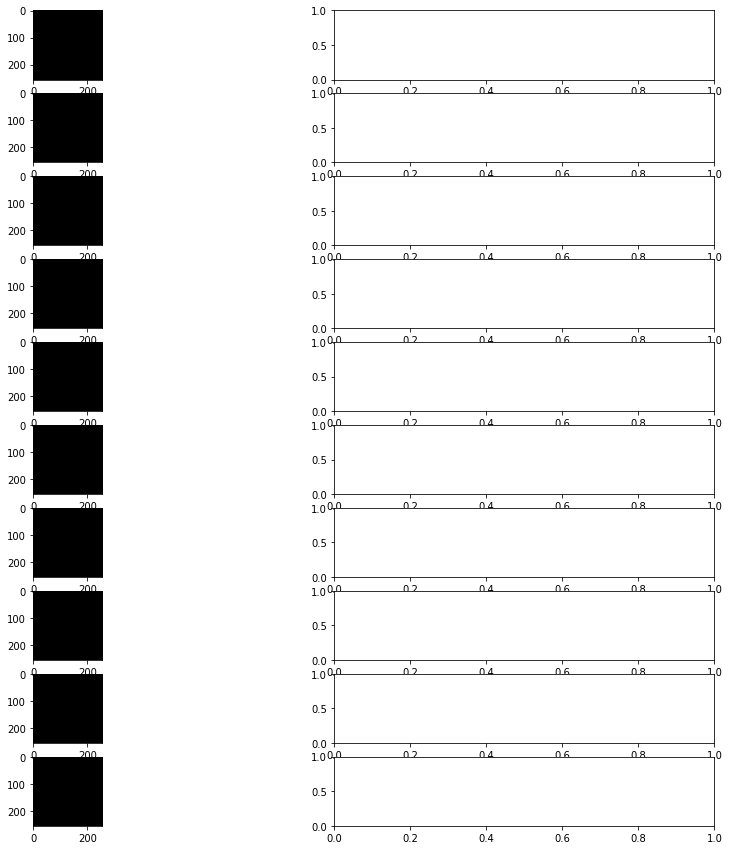

In [ ]:
te_data    = np.load('data_test.npy')
fig,ax = plt.subplots(10,2,figsize=[15,15])

for idx in range(10):
    ax[idx, 0].imshow(np.uint8(te_data[idx]))

In [ ]:
te_data    = np.load('data_test.npy')

predictions = model.predict(te_data, batch_size=8, verbose=1)

y_scores = predictions.reshape(predictions.shape[0]*predictions.shape[1]*predictions.shape[2]*predictions.shape[3], 1)
print(y_scores.shape)

y_scores = np.where(y_scores>0.5, 1, 0)

predictions = np.where(predictions>0.5, 1, 0)

2/2 [==============================] - 0s 63ms/step
(1048576, 1)


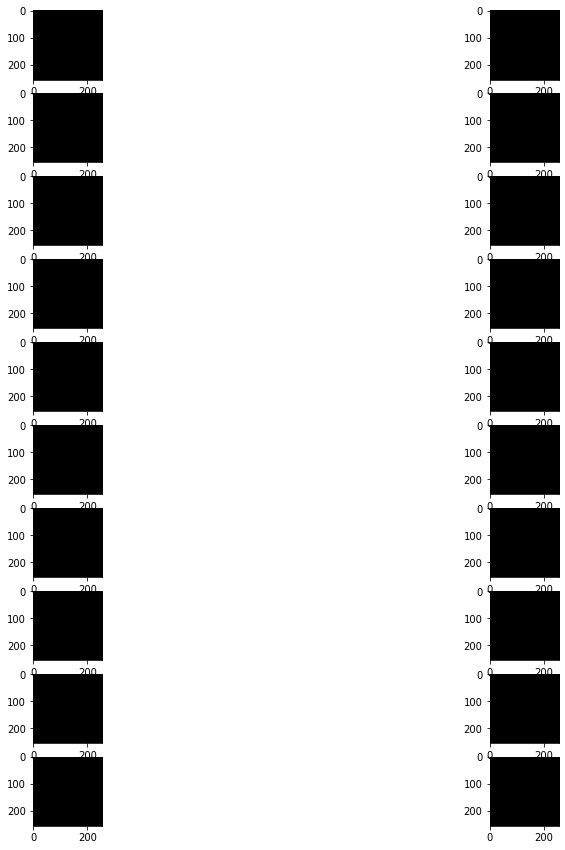

In [ ]:
for idx in range(predictions.shape[0]):
    esti_sample = predictions[idx]
    esti_sample = esti_sample.reshape(esti_sample.shape[0]*esti_sample.shape[1]*esti_sample.shape[2], 1)

  

fig,ax = plt.subplots(10,2,figsize=[15,15])

for idx in range(10):
    ax[idx, 0].imshow(np.uint8(te_data[idx]))
    #ax[idx, 1].imshow(np.squeeze(te_mask[good_prediction[idx,0]]), cmap='gray')
    ax[idx, 1].imshow(np.squeeze(predictions[idx]), cmap='gray')

## Set up dataloader


### Create ISIC dataset class

In [ ]:
class ISIC2018SkinDataset():
    def __init__(self, df, transform=None):
        """
        Args:
            df: Main dataframe with all the data organized already            
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.df.loc[self.df.index[idx], 'image_path']
        image = Image.open(img_name)

        mask_name = self.df.loc[self.df.index[idx], 'mask_path']
        mask = Image.open(mask_name)

        label = self.df.loc[self.df.index[idx], 'label_encoded']
        fitzpatrick = self.df.loc[self.df.index[idx], 'fizpatrick_skin_type']
        if self.transform:
            image = self.transform(image)

        return image, mask, label, fitzpatrick

In [ ]:

def get_isic_2018_dataloaders(isic_df, batch_size=8, shuffle=True):
    all_domains = [1, 2, 3, 4, 5, 6]

    # Extract the input and target data from the DataFrame
    X = isic_df
    y = isic_df["label_encoded"]

    # Extract the group labels from the DataFrame
    groups = isic_df["fizpatrick_skin_type"]

    # group index based on FSK. Split into 80/20 for training, test. then 50/50 for test and validation
    print("Splitting up the dataset into train,test, validation datasets")
    grouped = isic_df.groupby("fizpatrick_skin_type")
    group_indexes = grouped.indices

    train_indexes = []
    test_indexes = []
    val_indexes = []

    for group, index_list in group_indexes.items():        
        index_train, index_test, _, _ = train_test_split(index_list, index_list, test_size=0.2, random_state=42)        
        train_indexes += list(index_train)

        index_test, index_val, _, _ = train_test_split(index_test, index_test, test_size=0.5, random_state=42)        
        test_indexes += list(index_test)        
        val_indexes += list(index_val)

        print("fizpatrick_skin_type:",group, len(index_list))
        print(f"\t train {len(index_train)}")
        print(f"\t test {len(index_test)}")
        print(f"\t val {len(index_val)}")

    print(f"total_train: {len(train_indexes)} {len(train_indexes)/len(isic_df)*100}")
    print(f"total_test: {len(test_indexes)} {len(test_indexes)/len(isic_df)*100}")
    print(f"total_val: {len(val_indexes)} {len(val_indexes)/len(isic_df)*100}")

    train = isic_df.iloc[train_indexes]
    test = isic_df.iloc[test_indexes]
    val = isic_df.iloc[val_indexes]



    # # Create the GroupShuffleSplit object
    # gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    # # Split the data into training, test, and validation sets
    # for train_index, test_index in gss.split(X, y, groups=groups):
    #     train, X_test = X.iloc[train_index], X.iloc[test_index]
    #     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    # # Split the test set into test and validation sets
    # gss = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    # for test_index, val_index in gss.split(X_test, y_test, groups=groups[test_index]):
    #     test, val = X_test.iloc[test_index], X_test.iloc[val_index]
    #     y_test, y_val = y_test.iloc[test_index], y_test.iloc[val_index]
    
    print(f"train size: {len(train)}")
    print(f"test size: {len(test)}")
    print(f"val size: {len(val)}")

    
    for s in all_domains:
        print("\ttrain: skin type", s, ":", len(train[train['fizpatrick_skin_type'] == s]))

    print("----")
    for s in all_domains:
        print("\ttest: skin type", s, ":", len(test[test['fizpatrick_skin_type'] == s]))
    
    print("----")
    for s in all_domains:
        print("\tval: skin type", s, ":", len(val[val['fizpatrick_skin_type'] == s]))


    print("train size:", len(train))
    print("val size:", len(val))
    print("train skin types:", train.fizpatrick_skin_type.unique())
    print("val skin types:", val.fizpatrick_skin_type.unique())
    label_codes = sorted(list(train['label'].unique()))
    print("train skin conditions:", len(label_codes))
    label_codes1 = sorted(list(val['label'].unique()))
    print("val skin conditions:", len(label_codes1))

    transformed_train = ISIC2018SkinDataset(
        df=train,        
        transform=transforms.Compose([
            transforms.RandomRotation(degrees=15),
            transforms.RandomHorizontalFlip(),
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    )

    transformed_val = ISIC2018SkinDataset(
        df=val,
        transform=transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    )

    transformed_test = ISIC2018SkinDataset(
        df=test,
        transform=transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    )

    train_loader = torch.utils.data.DataLoader(
        transformed_train,
        batch_size=batch_size,
        drop_last=True)

    val_loader = torch.utils.data.DataLoader(
        transformed_val,
        batch_size=batch_size,
        shuffle=shuffle, drop_last=True)

    test_loader = torch.utils.data.DataLoader(
        transformed_test,
        batch_size=batch_size,
        shuffle=False, drop_last=False)

    return train_loader, val_loader, test_loader

In [ ]:
get_isic_2018_dataloaders(isic_df)

Splitting up the dataset into train,test, validation datasets
fizpatrick_skin_type: 1 8001
	 train 6400
	 test 800
	 val 801
fizpatrick_skin_type: 2 1049
	 train 839
	 test 105
	 val 105
fizpatrick_skin_type: 3 513
	 train 410
	 test 51
	 val 52
fizpatrick_skin_type: 4 182
	 train 145
	 test 18
	 val 19
fizpatrick_skin_type: 5 107
	 train 85
	 test 11
	 val 11
fizpatrick_skin_type: 6 163
	 train 130
	 test 16
	 val 17
total_train: 8009 79.9700449326011
total_test: 1001 9.995007488766849
total_val: 1005 10.034947578632051
train size: 8009
test size: 1001
val size: 1005
	train: skin type 1 : 6400
	train: skin type 2 : 839
	train: skin type 3 : 410
	train: skin type 4 : 145
	train: skin type 5 : 85
	train: skin type 6 : 130
----
	test: skin type 1 : 800
	test: skin type 2 : 105
	test: skin type 3 : 51
	test: skin type 4 : 18
	test: skin type 5 : 11
	test: skin type 6 : 16
----
	val: skin type 1 : 801
	val: skin type 2 : 105
	val: skin type 3 : 52
	val: skin type 4 : 19
	val: skin type 5 :

(<torch.utils.data.dataloader.DataLoader at 0x7fe4825083a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe482508ac0>)

# IF ERROR, RESTART RUNTIME due to derm-ita lib
This is due to derm-ita using newer libaries than the Google Colab default(during this time of 12/24/2022)

# Fitzpatrick Utilities

In [ ]:
Fitzpatrick_Skin_Type = Enum("Fitzpatrick_Skin_Type", ["_1","_2","_3","_4","_5","_6"])

In [ ]:
from numpy.random.mtrand import randint


def random_ita_from_FST(skin_type: Fitzpatrick_Skin_Type):
  """
  This function will return a random number between the ITA ranges provided in
  https://openaccess.thecvf.com/content/CVPR2021W/ISIC/papers/Groh_Evaluating_Deep_Neural_Networks_Trained_on_Clinical_Images_in_Dermatology_CVPRW_2021_paper.pdf
    For skin types of 6 and 1 there are open ranges. The selected end ranges comes from computing the ITA
    on all the ISIC 2017 dataset images and takeing the largest ranges.
  :skin_type - input of the Fitzpatrick skin type
  """
  if skin_type == Fitzpatrick_Skin_Type._6:
    return randint(-10,10)
  elif skin_type == Fitzpatrick_Skin_Type._5:
    return randint(10,19)
  elif skin_type == Fitzpatrick_Skin_Type._4:
    return randint(19,28)
  elif skin_type == Fitzpatrick_Skin_Type._3:
    return randint(28,41)
  elif skin_type == Fitzpatrick_Skin_Type._2:
    return randint(41,55)
  elif skin_type == Fitzpatrick_Skin_Type._1:
    return randint(55,90)

In [ ]:
def random_FST(exclude=None):
    """
    This function will randomly pick a fitzpatrick skin type 
    :exclude - given a FST, this will not be chosen when randomly picking a FST
    """
    if exclude is None:
        return Fitzpatrick_Skin_Type[f"_{random.randint(1,6)}"]
    else:
        while True:
            fst = Fitzpatrick_Skin_Type[f"_{random.randint(1,6)}"]
            if fst != exclude:
                return fst

# ISIC set up dataframe

In [ ]:
def strip_filename(file):
    """
    This function makes an identifier that matches between both the base image and the masked image
    """
    if DATASET_USED == "ISIC_2017":
        # Cleaning files names here: https://github.com/manideep2510/melanoma_segmentation.git
        fn = file.name.replace("imgx","")
        fn = fn.replace("imgy","")
        path = file.parent.parts[-1].replace("x","").replace("y","")

    # Cleaning ISIC 2016 filenames
    if DATASET_USED == "ISIC_2016":
        fn = file.name.replace("_Segmentation","").replace(".jpg","").replace(".png","")
        path = file.parent.parts[-1].replace("_Data","").replace("_GroundTruth","")

    if DATASET_USED == "ISIC_2018":
        fn = file.name.replace("_segmentation","").replace(".jpg","").replace(".png","")
        path = file.parent.parts[-1].replace("-2_Training_Input","").replace("_Training_GroundTruth","")
    
    uuid = f"{path}/{fn}"
    return uuid

In [ ]:
def apply_mask_and_get_jpeg_bytes(image_path, mask_path):
  # Load the image and the mask
  image = Image.open(image_path)
  mask = Image.open(mask_path)

  # Invert the mask
  #mask = ImageOps.invert(mask)

  # Convert the mask to a boolean array
  mask = mask.convert("1")

  # Apply the mask to the image
  image.paste(0, mask=mask)

  # Create a BytesIO object to hold the JPEG data
  jpeg_bytes = io.BytesIO()

  # Save the image to the BytesIO object as a JPEG
  image.save(jpeg_bytes, format="JPEG")

  # Seek to the beginning of the BytesIO object
  jpeg_bytes.seek(0)

  # Return the JPEG data as a bytes object
  return jpeg_bytes.read()

In [ ]:
%%time
dict_data = {}
data_list = []
for file in orig_images:    
    dict_data[strip_filename(file)] = file

for file in masks_images:
    
    # Adding the previous image to the new item so it will include both mask and image    
    image = open(dict_data[strip_filename(file)],"rb").read()    
    mask = open(file,"rb").read()

    # now to cut the mask out of the image
    masked_image = apply_mask_and_get_jpeg_bytes(dict_data[strip_filename(file)], file)
    data_list.append([strip_filename(file), image, mask, masked_image, file ])

# now to create the dataframe
df = pd.DataFrame(data=data_list, columns=["ID","image", "mask", "masked_image","file"])

# Skin transformer

In [ ]:
def safe_convert(x, new_dtype):
    info = np.iinfo(new_dtype)
    return x.clip(info.min, info.max).astype(new_dtype)

In [ ]:
def transform_image(image, mask, desired_fst=None, verbose=False):
    """
    1. Compute ITA of current image and retrieve Fitzpatrick skin type​
    2. Select random FST that’s different​
    3. Select random ITA number within range of selected FST​
    4. Compute difference  original ITA – new desired ITA​
    5. Adjusted b = old b value + (difference * .5)​
    6. Adjusted L = old L value + (difference * .12)
    :image - rgb image
    """
    
    image_ita = get_cropped_center_ita(image)
    if verbose: print(f"ITA {image_ita}")

    fst = Fitzpatrick_Skin_Type[f"_{get_kinyanjui_groh_type(image_ita)}"]
    if verbose: print(f"FST {fst}")
    
    # select random FST unless specified
    if desired_fst == None:
        random_fst = random_FST(exclude=fst)
    else:
        random_fst = desired_fst

    if verbose: print(f"Random FST: {random_fst}")

    random_ita = random_ita_from_FST(random_fst)
    if verbose: print(f"Random ita: {random_ita}")

    difference = image_ita - random_ita
    if verbose: print(f"Difference ita: {difference}")

    # convert to boolean array
    mask = ImageOps.invert(mask)
    mask = mask.convert("1")

    # convert base image to NumPy array
    image_array = np.array(image)

    # Convert the base image NumPy array to a LAB color space
    lab_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2LAB)

    # Create the modifiers
    if random_fst.value < fst.value:
        b_modifier = .31
        l_modifier = -.09
        a_modifier = -.06    
    else:
        if diff >25:
            b_modifier = .76
            l_modifier = -.85
        else:
            b_modifier = .56
            l_modifier = -.65
        a_modifier = .1    
    if verbose:print(f"b_modifier: {b_modifier} random_fst.value {random_fst} {random_fst.value} fst.value {fst} {fst.value}")
    
    # Convert to int64's incase we have negative numbers due to the modifier
    lab_image = safe_convert(lab_image,np.int64)            
    
    lab_image[:,:,2][mask] += int(difference * b_modifier)
    lab_image[:,:,1][mask] += int(difference * a_modifier)        
    lab_image[:,:,0][mask] += int(difference * l_modifier)

    # convert back to uint8's as thats what cv2 expects
    lab_image = safe_convert(lab_image,np.uint8)

    # Convert the image back to the original color space
    adjusted_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)

    if verbose:
        # Save the LAB image to a file
        cv2.imwrite("test.jpg", adjusted_image)
            
        image = Image.open(io.BytesIO(open("test.jpg","rb").read()))
            
        image_ita = get_cropped_center_ita(image)    
        print(f"Updated ITA {image_ita}")
    
    # To get a PIL image type you need to do this:
    # Image.fromarray(util.img_as_ubyte(rgb))
    # source: https://stackoverflow.com/a/55893334
    return adjusted_image

## Copy over Fitzpatrick files from Google Drive to local directory

In [ ]:
# Make sure to connect google drive in the files section over on the left hand side of Google Colab
!ls -l
%cp /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/fitzpatrick17k.zip /content/CIRCLe/

total 13676
drwxr-xr-x 2 root root     4096 Jan  2 07:59 images
drwxr-xr-x 4 root root     4096 Jan  2 08:08 ISIC_2018
drwxr-xr-x 3 root root     4096 Jan  2 08:08 ISIC_2018_GT
-rw-r--r-- 1 root root    36681 Mar 16  2020 ISIC2018_Task3_Training_GroundTruth.zip
-rw-r--r-- 1 root root 13870621 Jan  2 08:02 ISIC2018_Task3_Training_Input.zip
-rw-r--r-- 1 root root    34523 Jan  2 07:59 LICENSE
-rwxr-xr-x 1 root root      419 Jan  2 07:59 logger.py
-rwxr-xr-x 1 root root     5174 Jan  2 09:18 main.py
drwxr-xr-x 3 root root     4096 Jan  2 08:42 models
drwxr-xr-x 5 root root     4096 Jan  2 08:56 organize_data
drwxr-xr-x 2 root root     4096 Jan  2 08:02 __pycache__
-rw-r--r-- 1 root root     3245 Jan  2 07:59 README.md
-rw-r--r-- 1 root root      127 Jan  2 07:59 requirements.txt
drwxr-xr-x 2 root root     4096 Jan  2 07:59 skin_transformer
drwxr-xr-x 2 root root     4096 Jan  2 07:59 star_gan
-rwxr-xr-x 1 root root      356 Jan  2 07:59 util.py


In [ ]:
# Unpack fitzpatrick 17k dataset
file_name_with_path = "/content/CIRCLe/fitzpatrick17k.zip"
with zipfile.ZipFile(file_name_with_path, 'r') as zip_ref:
    zip_ref.extractall("/content/CIRCLe")

In [ ]:
path_to_files = "/content/CIRCLe/data/finalfitz17k/"

In [ ]:
# Copy over csv files to where the images are located
!cp ./*.csv $path_to_files

cp: cannot stat './*.csv': No such file or directory


#Tranining StarGAN

In [ ]:
# Create folder for where the STAR Gan files will be saved
%mkdir ./gan-path

mkdir: cannot create directory ‘./gan-path’: File exists


In [ ]:
!python train_stargan.py --model_save_dir ./gan-path --data_dir $path_to_files

Namespace(batch_size=16, beta1=0.5, beta2=0.999, c_dim=6, d_conv_dim=64, d_lr=0.0001, d_repeat_num=6, data_dir='/content/CIRCLe/data/finalfitz17k/', dataset='FitzPatrick17k', g_conv_dim=64, g_lr=0.0001, g_repeat_num=6, image_size=128, lambda_cls=1, lambda_gp=10, lambda_rec=10, log_dir='stargan/logs', log_step=10, lr_update_step=1000, mode='train', model_save_dir='./gan-path', model_save_step=10000, n_critic=5, num_iters=1000000, num_iters_decay=200000, num_workers=1, resume_iters=None, sample_step=1000, test_iters=20000, use_tensorboard=False)
	train: skin type 1 : 2358
	train: skin type 2 : 3842
	train: skin type 3 : 2658
	train: skin type 4 : 2220
	train: skin type 5 : 1217
	train: skin type 6 : 515
train size: 12810
val size: 1603
train skin types: [4 6 2 3 1 5]
val skin types: [3 2 4 5 1 6]
train skin conditions: 114
val skin conditions: 114
Generator(
  (main): Sequential(
    (0): Conv2d(15, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2

## Copy StarGAN models over to Google Drive

In [ ]:
#%cp ./gan-path/*.ckpt /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/

In [ ]:
# copy the StarGAN models back over to local
%cp /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/*.ckpt /content/CIRCLe/gan-path

# Train CIRCLe model 

In [66]:
%mkdir ./saved
%mkdir ./saved/model

In [ ]:
!cp ./organize_data/fitzpatrick_17k_dataset/*.csv ./data/finalfitz17k/

In [63]:
!git checkout -- ./models/circle.py

In [64]:
!git pull

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5 (delta 2), reused 5 (delta 2), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/acorbin3/CIRCLe
   3825a7f..cd68a22  main       -> origin/main
Updating 3825a7f..cd68a22
Fast-forward
 organize_data/isic_2018/dataset.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [ ]:
!python main.py --use_reg_loss True --base mobilenetv3l --dataset isic2018

Flags:
	alpha: 0.1
	base: mobilenetv3l
	batch_size: 32
	data_dir: ./data/finalfitz17k/
	dataset: isic2018
	epochs: 100
	gan_path: saved/stargan/
	hidden_dim: 256
	lr: 0.001
	model: circle
	model_save_dir: saved/model/
	num_classes: 7
	seed: 1
	use_reg_loss: True
	weight_decay: 0.001
isic2018 images already downloaded
isic 2018 masks already downladed
Donloading isic 2018 ground truth classification data
Creating dataframe
	 Looking for cached dataframe
		 organize_data/isic_2018/saved_data_2022_12_27_isic_2018.csv
Creating dataframe. Complete!
Splitting up the dataset into train,test, validation datasets
fizpatrick_skin_type: 1 8001
	 train 6400
	 test 800
	 val 801
fizpatrick_skin_type: 2 1049
	 train 839
	 test 105
	 val 105
fizpatrick_skin_type: 3 513
	 train 410
	 test 51
	 val 52
fizpatrick_skin_type: 4 182
	 train 145
	 test 18
	 val 19
fizpatrick_skin_type: 5 107
	 train 85
	 test 11
	 val 11
fizpatrick_skin_type: 6 163
	 train 130
	 test 16
	 val 17
total_train: 8009 79.9700449

In [ ]:
!wget https://isic2018task3masks.s3.amazonaws.com/isic_2018_mask_results1_2022_12_29.zip

--2023-01-01 09:12:25--  https://isic2018task3masks.s3.amazonaws.com/isic_2018_mask_results1_2022_12_29.zip
Resolving isic2018task3masks.s3.amazonaws.com (isic2018task3masks.s3.amazonaws.com)... 52.216.136.196, 52.216.187.35, 52.217.38.228, ...
Connecting to isic2018task3masks.s3.amazonaws.com (isic2018task3masks.s3.amazonaws.com)|52.216.136.196|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2023-01-01 09:12:25 ERROR 403: Forbidden.



In [ ]:
!unzip temp -d ISIC_2018 > /dev/null.

  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of temp or
        temp.zip, and cannot find temp.ZIP, period.


In [ ]:
print(torch.cuda.device_count())

1


In [ ]:
%mkdir /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/model_checkpoints

In [ ]:
%cp ./saved/model/*.ckpt /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/model_checkpoints